#### Notebook to analyse the distribution of systematics in pixels where Linear and DeepSet deviate

In [3]:
import pandas as pd
import time
import pickle
from models.deep_set.set_dataloader import CCD
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import numpy as np


Steps:

1. Separate corpus by extreme difference in linear and deep

In [4]:
gals = ['lrg', 'elg', 'qso']
areas = ['north', 'south', 'des']
zscore = lambda x: abs((x - x.median()) / x.std())


In [5]:
# Calculating the Z-value difference between Deep and Linear Models
area = 'north'
gal = 'elg'


df_test = pd.read_csv(f'results/{area}_complete.csv')
df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']


df_test[f'{gal}_Z'] = df_test[f'{gal}_LINEAR_VS_DEEP'].transform(zscore)

print(df_test[f'{gal}_Z'])

print(df_test.columns)

0        1.172081
1        0.204170
2        0.430176
3        0.128015
4        0.736912
           ...   
97507    0.191201
97508    0.760845
97509    0.971864
97510    0.595657
97511    1.322318
Name: elg_Z, Length: 97512, dtype: float64
Index(['pixel_id', 'lrg', 'elg', 'qso', 'exposures', 'stellar', 'EBV',
       'airmass', 'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'exptime_g',
       'exptime_r', 'exptime_z', 'meansky_g', 'meansky_r', 'meansky_z',
       'seeing_g', 'seeing_r', 'seeing_z', 'lrg_lin', 'elg_lin', 'qso_lin',
       'lrg_nn', 'elg_nn', 'qso_nn', 'lrg_deep', 'y_gold_x', 'elg_deep',
       'y_gold_y', 'qso_deep', 'y_gold', 'elg_LINEAR_VS_DEEP', 'elg_Z'],
      dtype='object')


In [6]:
# Separating into two corpus

In [7]:
df_diff = df_test[df_test[f'{gal}_Z'] > 2]
df_no_diff = df_test[df_test[f'{gal}_Z'] <= 2]

print(len(df_diff))
print(len(df_no_diff))
print(len(df_diff)/len(df_no_diff))
print(df_diff.head())

3443
94069
0.036600793034899916
    pixel_id  lrg  elg  qso  exposures   stellar       EBV   airmass  \
5      82226   24  139  136   0.272727  0.389121  0.691390  0.269643   
12     13805   33  148  191   0.202797  0.104603  0.104795  0.455058   
22     88025   33  122  150   0.279720  0.230126  0.278899  0.079172   
39    185223   15   83   91   0.615385  0.037657  0.076639  0.628326   
51     21577   22  107  104   0.216783  0.096234  0.144741  0.327416   

    ccdskysb_g  ccdskysb_r  ...      elg_nn      qso_nn   lrg_deep  y_gold_x  \
5     0.669890    0.504869  ...  112.357765  137.443802  39.370529      24.0   
12    0.798852    0.453930  ...  122.563126  159.401733  34.844891      33.0   
22    0.641070    0.557464  ...  121.627251  136.937286  37.247723      33.0   
39    0.674481    0.585174  ...  126.687256  116.244797  33.838257      15.0   
51    0.820230    0.724263  ...  122.315102  154.590851  35.375160      22.0   

      elg_deep  y_gold_y    qso_deep  y_gold  elg_LINE

2. Identify all CCDs that cover a given pixel in deepset --> use set for that

A. Get all Subpixels for the pixels in the DF
B. Get all CCDs for all these subpixels and create a set

In [8]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()


0.058106 minutes (3.49 seconds) taken to import the dict



In [9]:
pix_ids_diff = list(df_diff.pixel_id)
ccd_ids_diff = set()

ccds_per_pix = []
for id in pix_ids_diff:
    ccds_per_pix.append(len(pixel2ccd_dict[id]))
    # Iterate through all Pixels with large deviations in prediction
    for elem in pixel2ccd_dict[id]:
        # Add all CCDs to the set --> only unique one's will be retained
        ccd_ids_diff.add(elem)

print(len(ccd_ids_diff))

print("Average CCDs per pixel in diff", sum(ccds_per_pix)/len(ccds_per_pix))

df_diff.exposures = np.array(ccds_per_pix)

86383
Average CCDs per pixel in diff 46.8370607028754


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
ccd = CCD()

# Get the available data for the list CCD ids in the deviating set

data_diff = ccd.get_ccds(list(ccd_ids_diff))

print(data_diff)

[['195.0' '2.17' '1.4432356' '20.147465' '2.4538672' 'z']
 ['195.0' '2.17' '1.4206523' '20.146729' '2.453416' 'z']
 ['195.0' '2.17' '1.4282845' '20.143763' '2.443515' 'z']
 ...
 ['166.0' '2.14' '1.2092987' '20.207922' '2.5305955' 'z']
 ['109.927' '1.21' '0.93009996' '23.342793' '0.2822703' 'g']
 ['109.927' '1.21' '0.88293993' '23.344662' '0.28262067' 'g']]


In [11]:
ccd_df_diff = pd.DataFrame(data_diff, columns=['exptime',
                          'airmass',
                          'seeing',
                          'ccdskysb',
                          'meansky',
                           'filter'])


ccd_df_diff.head()

,exptime,airmass,seeing,ccdskysb,meansky,filter
0,195.0,2.17,1.4432356,20.147465,2.4538672,z
1,195.0,2.17,1.4206523,20.146729,2.453416,z
2,195.0,2.17,1.4282845,20.143763,2.443515,z
3,195.0,2.17,1.4521575,20.145058,2.4430056,z
4,195.0,2.17,1.4803694,20.14509,2.4630578,z


Repeat the same for the pixels that do not have a large difference

In [12]:
pix_ids_no_diff = list(df_no_diff.pixel_id)
ccd_ids_no_diff = set()

ccds_per_pix = []

for id in pix_ids_no_diff:
    ccds_per_pix.append(len(pixel2ccd_dict[id]))
    # Iterate through all Pixels with large deviations in prediction
    for elem in pixel2ccd_dict[id]:
        # Add all CCDs to the set --> only unique one's will be retained
        ccd_ids_no_diff.add(elem)

print(len(ccd_ids_no_diff))

print("Average CCDs per pixel in no_diff", sum(ccds_per_pix)/len(df_no_diff))
print(df_no_diff.head())
df_no_diff.exposures = np.array(ccds_per_pix)
print(df_no_diff.head())


444513
Average CCDs per pixel in no_diff 40.26732504863451
   pixel_id  lrg  elg  qso  exposures   stellar       EBV   airmass  \
0     20930   37   63  166   0.230769  0.271967  0.578446  0.447089   
1    128915   27  156  146   0.209790  0.062762  0.060792  0.066278   
2     22899   21   95  114   0.188811  0.092050  0.049091  0.371570   
3    105934   38  100  150   0.181818  0.104603  0.051809  0.056693   
4     14825   26  113  121   0.181818  0.083682  0.077518  0.410721   

   ccdskysb_g  ccdskysb_r  ...      elg_nn      qso_nn   lrg_deep  y_gold_x  \
0    0.762753    0.492800  ...  106.447639  151.082962  38.373226      37.0   
1    0.720468    0.591275  ...  137.959015  148.486588  33.768410      27.0   
2    0.772063    0.579600  ...  124.564796  162.211380  34.356449      21.0   
3    0.862060    0.616452  ...  125.339645  160.024933  34.971714      38.0   
4    0.817044    0.601693  ...  124.900391  157.971161  34.321514      26.0   

     elg_deep  y_gold_y    qso_deep  y_

/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
ccd = CCD()

# Get the available data for the list CCD ids in the deviating set

data_no_diff = ccd.get_ccds(list(ccd_ids_no_diff))

print(data_no_diff)

[['195.0' '2.17' '1.4416313' '20.147415' '2.4361064' 'z']
 ['195.0' '2.17' '1.4716448' '20.152155' '2.428209' 'z']
 ['195.0' '2.17' '1.4876887' '20.146786' '2.470628' 'z']
 ...
 ['195.0' '2.17' '1.5272663' '20.14737' '2.4503837' 'z']
 ['195.0' '2.17' '1.4211624' '20.14563' '2.459542' 'z']
 ['195.0' '2.17' '1.4287281' '20.149017' '2.473841' 'z']]


In [14]:
ccd_df_no_diff = pd.DataFrame(data_no_diff, columns=['exptime',
                          'airmass',
                          'seeing',
                          'ccdskysb',
                          'meansky',
                           'filter'])


ccd_df_no_diff.head()


,exptime,airmass,seeing,ccdskysb,meansky,filter
0,195.0,2.17,1.4416313,20.147415,2.4361064,z
1,195.0,2.17,1.4716448,20.152155,2.428209,z
2,195.0,2.17,1.4876887,20.146786,2.470628,z
3,195.0,2.17,1.4824165,20.146584,2.4686885,z
4,195.0,2.17,1.4432356,20.147465,2.4538672,z



3. Plot difference in inputs for all pixels in each catalogue


In [15]:
pix_metrics = {"EBV", "stellar",  "exposures"}
uni_metrics = {"airmass", "filter"}
band_metrics = {'exptime','seeing','ccdskysb','meansky'}

In [29]:

nrows = 10
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))
#plt.title("Raw Test Set Systematics Dependency - North")
#fig = plt.figure()
i = 0


col = ["EBV","EBV", "stellar","stellar","exposures","exposures", "airmass","airmass", "filter","filter"]# ,'exptime','seeing','ccdskysb','meansky']
for ax in ax.flatten():

    if i % 2 == 0:
        df_ccd = ccd_df_diff
        df = df_diff
    else:
        df_ccd = ccd_df_no_diff
        df = df_no_diff

    x_label = col[i]
    plt.axes(ax)

    print(x_label)

    if x_label in uni_metrics:

        plt.hist(df_ccd[x_label])
        plt.xlabel(x_label)
        i+=1
        continue

    if x_label in pix_metrics:

        plt.hist(df[x_label])
        plt.xlabel(x_label)
        i+=1
        continue

    break


    for colour in 'g', 'r', 'z':

        df_col = df[df['filter'] == colour]



        plt.hist(df_col[x_label])
        plt.xlabel(f'{x_label}_{colour}')
        i+=1


#fig.tight_layout(pad=3.0)

plt.show()




EBV
EBV
stellar
stellar
exposures
exposures
airmass
airmass
filter
filter


KeyboardInterrupt: 

In [17]:
print(f'Difference in CCD Metrics for {area} {gal}')

Difference in CCD Metrics for north_elg


0


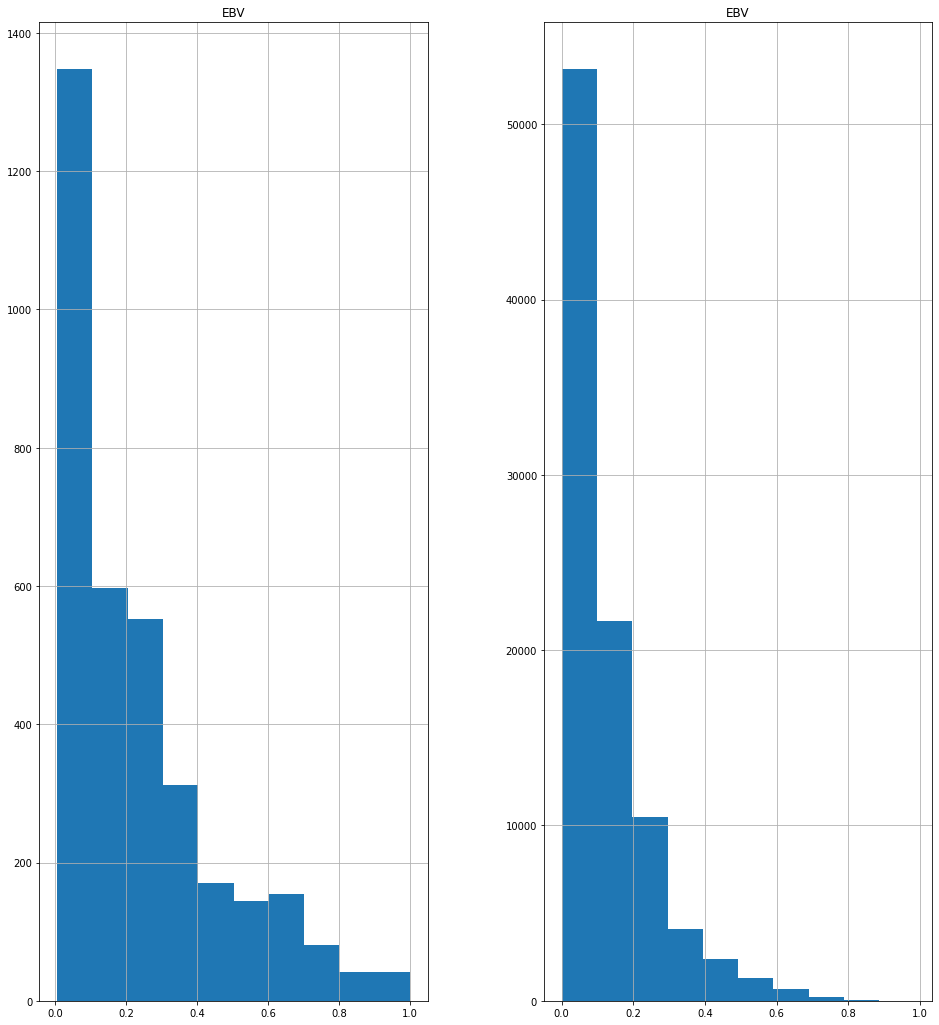

In [19]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))

print(i)
df_diff.hist('EBV', ax=axes[0])
df_no_diff.hist('EBV', ax=axes[1])
plt.show()

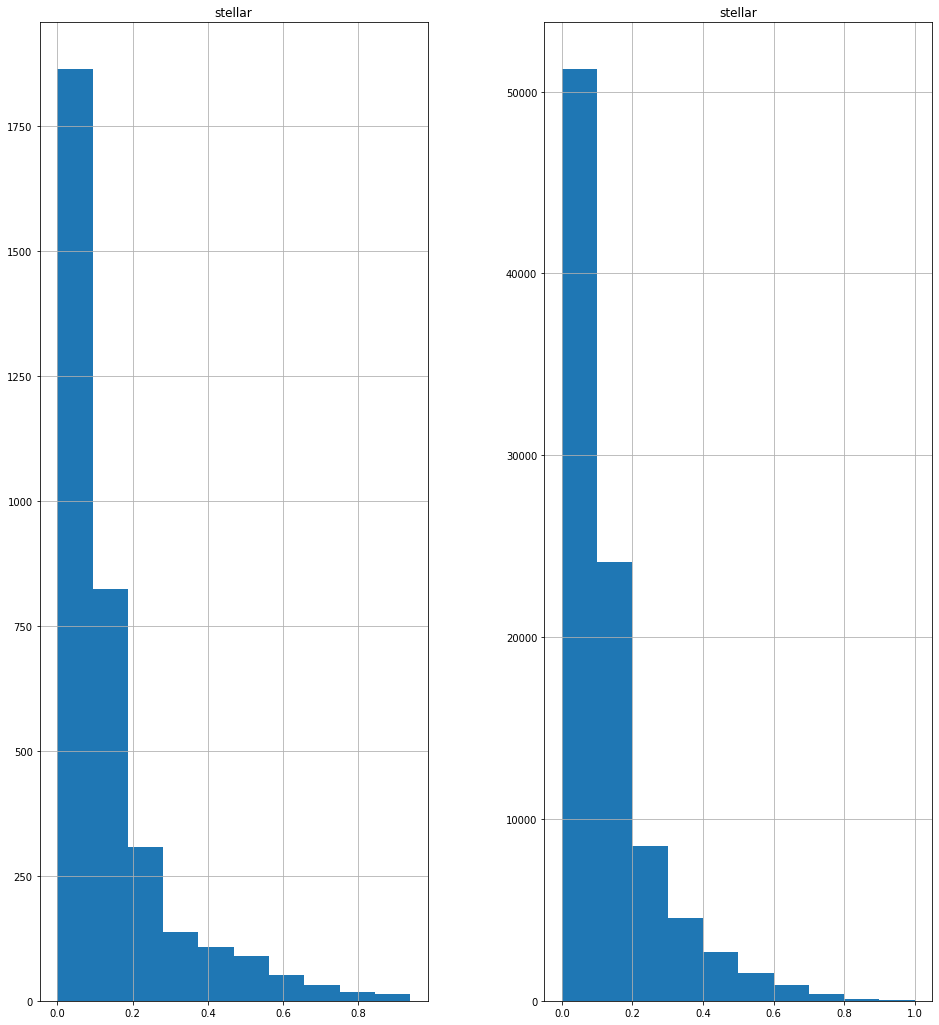

In [20]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))



df_diff.hist('stellar', ax=axes[0])
df_no_diff.hist('stellar', ax=axes[1])
plt.show()


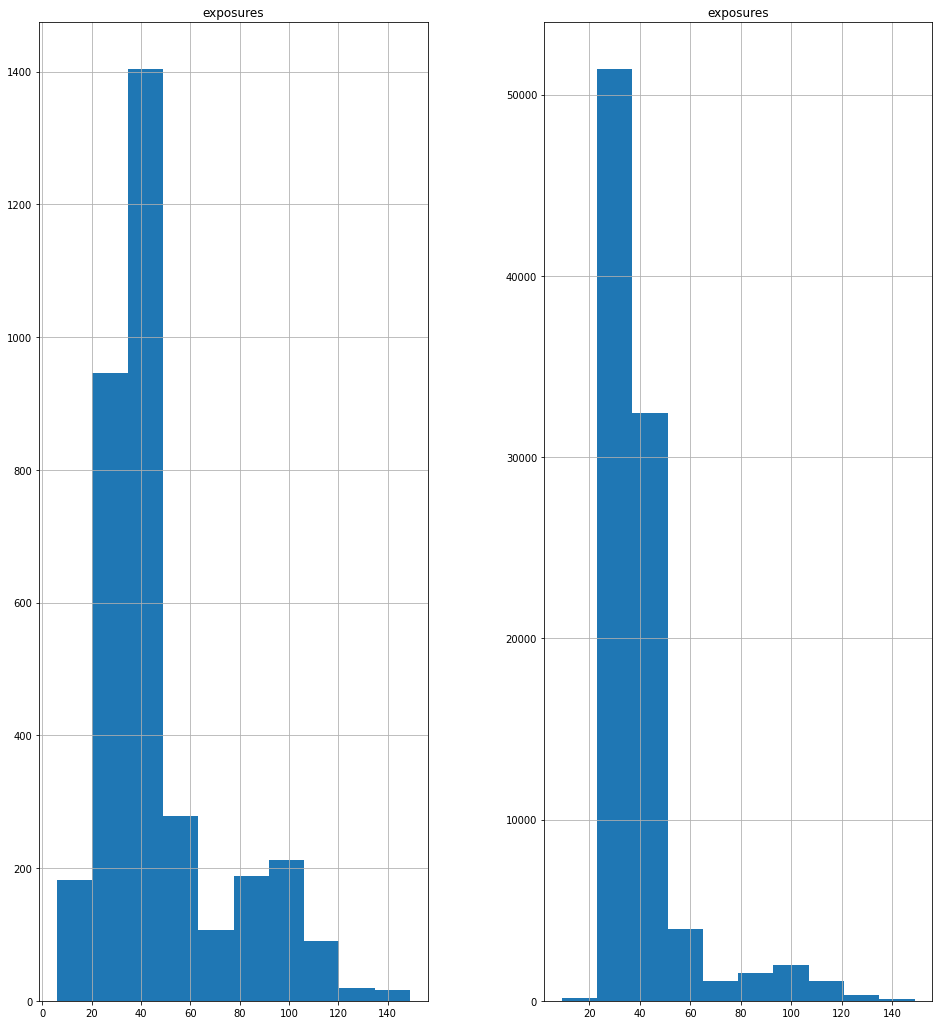

In [22]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))


df_diff.hist('exposures', ax=axes[0])
df_no_diff.hist('exposures', ax=axes[1])
plt.show()

In [ ]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))

plt.axes(axes[0])
plt.hist(ccd_df_diff['airmass'])
plt.xlabel('airmass')
plt.axes(axes[1])
plt.hist(ccd_df_no_diff['airmass'])
plt.xlabel('airmass')
plt.show()

In [ ]:

g_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'g']
g_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'g']

i += 1
print(i)


for elem in band_metrics:

    plt.axes(axes[i,0])
    plt.hist(g_df_col_diff[elem])
    plt.xlabel(f'{elem}_g')

    plt.axes(axes[i,1])
    plt.hist(g_df_col_no_diff[elem])
    plt.xlabel(f'{elem}_g')

    i+=1
    print(i)




r_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'r']
r_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'r']


for elem in band_metrics:

    plt.axes(axes[i,0])
    plt.hist(r_df_col_diff[elem])
    plt.xlabel(f'{elem}_r')

    plt.axes(axes[i,1])
    plt.hist(r_df_col_no_diff[elem])
    plt.xlabel(f'{elem}_r')

    i+=1
    print(i)


z_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'z']
z_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'z']


for elem in band_metrics:

    plt.axes(axes[i,0])
    plt.hist(z_df_col_diff[elem])
    plt.xlabel(f'{elem}_z')

    plt.axes(axes[i,1])
    plt.hist(z_df_col_no_diff[elem])
    plt.xlabel(f'{elem}_z')

    i+=1
    print(i)


print("Here")

#fig.tight_layout(pad=3.0)

time_start = time.time()
plt.show()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to plt.show()")
print()



print(f'Percent of g-band exposures of all exposures in Diff: {len(g_df_col_diff)/len(g_df_diff)}')
print(f'Percent of g-band exposures of all exposures in No - Diff: {len(g_df_col_no_diff)/len(g_df_no_diff)}')

print(f'Percent of r-band exposures of all exposures in Diff: {len(r_df_col_diff)/len(r_df_diff)}')
print(f'Percent of r-band exposures of all exposures in No - Diff: {len(r_df_col_no_diff)/len(r_df_no_diff)}')

print(f'Percent of z-band exposures of all exposures in Diff: {len(z_df_col_diff)/len(z_df_diff)}')
print(f'Percent of z-band exposures of all exposures in No - Diff: {len(z_df_col_no_diff)/len(z_df_no_diff)}')




In [ ]:
nrows = 16
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))
plt.title(f"Difference in CCD Metrics for {area}_{gal}")

i = 0
print(i)
df_diff.hist('EBV', ax=axes[i,0])
df_no_diff.hist('EBV', ax=axes[i,1])

i += 1
df_diff.hist('stellar', ax=axes[i,0])
df_no_diff.hist('stellar', ax=axes[i,1])
print(i)

i += 1
df_diff.hist('exposures', ax=axes[i,0])
df_no_diff.hist('exposures', ax=axes[i,1])
print(i)

i += 1
plt.axes(axes[i,0])
plt.hist(ccd_df_diff['airmass'])
plt.xlabel('airmass')
plt.axes(axes[i,1])
plt.hist(ccd_df_no_diff['airmass'])
plt.xlabel('airmass')
print(i)


g_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'g']
g_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'g']

i += 1
print(i)


for elem in band_metrics:

    plt.axes(axes[i,0])
    plt.hist(g_df_col_diff[elem])
    plt.xlabel(f'{elem}_g')

    plt.axes(axes[i,1])
    plt.hist(g_df_col_no_diff[elem])
    plt.xlabel(f'{elem}_g')

    i+=1
    print(i)




r_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'r']
r_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'r']


for elem in band_metrics:

    plt.axes(axes[i,0])
    plt.hist(r_df_col_diff[elem])
    plt.xlabel(f'{elem}_r')

    plt.axes(axes[i,1])
    plt.hist(r_df_col_no_diff[elem])
    plt.xlabel(f'{elem}_r')

    i+=1
    print(i)


z_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'z']
z_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'z']


for elem in band_metrics:

    plt.axes(axes[i,0])
    plt.hist(z_df_col_diff[elem])
    plt.xlabel(f'{elem}_z')

    plt.axes(axes[i,1])
    plt.hist(z_df_col_no_diff[elem])
    plt.xlabel(f'{elem}_z')

    i+=1
    print(i)


print("Here")

#fig.tight_layout(pad=3.0)

time_start = time.time()
plt.show()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to plt.show()")
print()



print(f'Percent of g-band exposures of all exposures in Diff: {len(g_df_col_diff)/len(g_df_diff)}')
print(f'Percent of g-band exposures of all exposures in No - Diff: {len(g_df_col_no_diff)/len(g_df_no_diff)}')

print(f'Percent of r-band exposures of all exposures in Diff: {len(r_df_col_diff)/len(r_df_diff)}')
print(f'Percent of r-band exposures of all exposures in No - Diff: {len(r_df_col_no_diff)/len(r_df_no_diff)}')

print(f'Percent of z-band exposures of all exposures in Diff: {len(z_df_col_diff)/len(z_df_diff)}')
print(f'Percent of z-band exposures of all exposures in No - Diff: {len(z_df_col_no_diff)/len(z_df_no_diff)}')



  exptime airmass     seeing   ccdskysb    meansky filter
0   195.0    2.17  1.4432356  20.147465  2.4538672      z
1   195.0    2.17  1.4206523  20.146729   2.453416      z
2   195.0    2.17  1.4282845  20.143763   2.443515      z
3   195.0    2.17  1.4521575  20.145058  2.4430056      z
4   195.0    2.17  1.4803694   20.14509  2.4630578      z
